In [1]:
import math # cos() for Rastrigin
import copy # array-copying convenience
import sys # max float
import numpy as np
import sympy as sp
from sympy.plotting import plot
from sympy.plotting import plot3d
import matplotlib.pyplot as plt
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from ddpg_agent import Agent
import pandas as pd

In [2]:
## parameter/ constant
bandwidth = 1e6  # [hz]
Speed_of_light = 3e8  # [m/s]
Carrier_freq = 2e9  # [hz]=1/s
GBS_location = [0,0,20] #[m] 20
Num_GBS = 1
# NUM_User = 10
NUM_UAV = 2
Cell_Radius = 1000 #[m]
UAV_Height = 100#100 #[m] "Cell-Edge User Offloading via Flying UAV in Non-Uniform Heterogeneous Cellular Networks," in IEEE Transactions on Wireless Communications, vol. 19, no. 4, pp. 2411-2426, April 2020, doi: 10.1109/TWC.2020.2964656.
P_UAV = 10 **(37 / 10) / 1000 #[watt] 
P_GBS = 10 **(40 / 10) / 1000 #[watt]
P_MAX = 0.4 # 26dbm, user
# P_MIN = 0.1 # 20 dbm
epsilon = 0.38 # power amplifier efficiency
AWGN_DBM = -174 #[dBm]
AWGN_W = 10 ** (AWGN_DBM / 10) / 1000
air_density = 1.225 # Air density at sea level (kg/m³)
g = 9.81            # Gravitational acceleration (m/s²)
mass = 0.5           # Mass of UAV in kg
radius = 0.2         # Rotor radius in meters
num_rotors = 4
P_MOVE =10 #[watt]
V = 20 # m/s


In [3]:
#Area
AREA_WIDTH = 1000 #[m]
def random_position():
    # Generate a random position within the area
    x = np.random.uniform(-Cell_Radius, Cell_Radius)
    y = np.random.uniform(-Cell_Radius, Cell_Radius)
    return (x, y, 0)

User_position = []
for i in range(45):
    User_position.append(random_position())

UAV_2D = []
for i in range(2):
    UAV_2D.append(random_position())

UAV_position=[]
for i in range(2):
    # Convert to a list to modify it
    temp_list = list(UAV_2D[i])
    temp_list[2] = UAV_Height
    updated_tuple = tuple(temp_list)
    print(temp_list)
    UAV_position.append(updated_tuple)

[-493.91096025993807, 735.1287687128302, 100]
[-169.99821401449378, -802.6997114045413, 100]


In [5]:
def init_uav_positions(NUM_UAV, UAV_Height, random_position):

    UAV_2D = [random_position() for _ in range(NUM_UAV)]
    UAV_positions = []
    
    for i in range(NUM_UAV):
        temp_list = list(UAV_2D[i])
        temp_list[2] = UAV_Height
        updated_tuple = tuple(temp_list)
        # print(temp_list)
        UAV_positions.append(updated_tuple)
    
    return UAV_positions

In [ ]:
# initail location UAVs
UAV_position =np.array(UAV_position)

array([[-493.91096026,  735.12876871,  100.        ],
       [-169.99821401, -802.6997114 ,  100.        ]])

In [7]:
# Fixed location User
User_position = [
(653.8316581607805, -590.3141344883956, 0),
 (655.7839795019095, 511.39715579708627, 0),
 (-366.9200930533958, -378.53106855942656, 0),
 (774.0710077290566, -813.74371579118, 0),
 (-902.1513920204236, 689.4058695488745, 0),
 (-887.8742394199635, 629.5122712145035, 0),
 (-480.4469889568361, -411.7900064526441, 0),
 (-584.0565231366488, -207.29087777276175, 0),
 (917.8907259745158, -388.6065319450123, 0),
 (482.22239122176074, 382.7717524589923, 0),
#  (75.08205947,	-246.6113445,	0),
# (89.08034796,	93.40797308	,0),
# (539.8534823,	-160.3015493,	0),
# (139.7089773,	716.6716587	,0),
# (-569.3566777,	263.1666404	,0),
# (-90.29446879,	-288.6084637	,0),
# (-767.5899487,	-135.3924119,	0),
# (773.8435759	,-235.8694596	,0),
# (613.2944812	,608.7494777	,0),
# (204.2851089	,-171.0078052	,0),
# (386.1443989	,-926.5117843	,0),
# (-938.0904915	,99.43896713	,0),
# (-937.1604717,	-444.6725165	,0),
# (694.8819289	,668.5820704	,0),
# (834.6212365	,987.1367586,	0),
# (348.2927666	,-81.11493568	,0),
# (-955.8690815	,81.17473736	,0),
# (-545.2280657	,977.3220921	,0),
# (-700.3981729	,-579.959419	,0),
# (653.7133739	,-669.164471	,0),

# (348.2927666, -81.11493568, 0),
# (-955.8690815, 81.17473736, 0), 
# (-545.2280657, 977.3220921, 0), 
# (-700.3981729, -579.959419, 0), 
# (653.7133739, -669.164471, 0), 
# (-506.6846758, -705.9394417, 0), 
# (896.2006003, 877.8498844, 0), 
# (125.4253527, -538.2481854, 0), 
# (990.9906697, -488.4208938, 0), 
# (189.1648561, 928.506681, 0), 
# (621.151883, -959.0060838, 0), 
# (-15.72055139, -965.5771711, 0), 
# (-873.5564091, -242.8615793, 0), 
# (294.9378672, 189.1955228, 0), 
# (281.3142429, -43.80571487, 0),
#  (541.9741951, -799.123747, 0), 
#  (-803.0740695, -803.8707771, 0), 
#  (429.36194, -131.6410741, 0), 
#  (462.4096664, -446.1983873, 0), 
#  (673.7502046, -552.7129857, 0),
#    (943.1181771, 138.1393275, 0), 
#    (592.1487118, -137.7552784, 0), 
#    (-226.501086, 669.547165, 0), 
#    (-32.95758572, 221.2279866, 0), 
#    (-512.2890811, -546.7293695, 0)

]

In [ ]:
NUM_User = len(User_position)

10

In [9]:
#Calculate Distance
def distance(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
D_n_bs = np.zeros((NUM_UAV + Num_GBS, NUM_User))
D_n_bs

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
# # Calcualte distance store in Matrix
# UAV_position = np.array([[-483.06727465,   31.1365344 ,  100.        ],
#        [ 871.15504185, -927.74625029,  100.        ]])
# #UAV1
# for j in range(NUM_User):
#     uav_pos = UAV_position[0]
#     user_pos = User_position[j]
#     calculated_distance = distance(x1 = uav_pos[0], y1 = uav_pos[1], z1 = uav_pos[2], x2 = user_pos[0], y2 = user_pos[1], z2 = user_pos[2])
    
#     # Store the calculated distance in the matrix
#     D_n_bs[0][j] = calculated_distance

# #UAV2
# for j in range(NUM_User):
#     uav_pos = UAV_position[1]
#     user_pos = User_position[j]
#     calculated_distance = distance(x1 = uav_pos[0], y1 = uav_pos[1], z1 = uav_pos[2], x2 = user_pos[0], y2 = user_pos[1], z2 = user_pos[2])
#     D_n_bs[1][j] = calculated_distance

# #Ground BS
# for j in range(NUM_User):
#     user_pos = User_position[j]
#     calculated_distance = distance(x1 = GBS_location[0], y1 = GBS_location[1], z1 = GBS_location[2], x2 = user_pos[0], y2 = user_pos[1], z2 = user_pos[2])
#     D_n_bs[2][j] = calculated_distance    
    
# # print("distance user to all base staion",D_n_bs)

In [11]:
#pathloss, unitless
def gain_n(distance):
    c = Speed_of_light
    f= Carrier_freq
    pi = np.pi
    return (c/(4*pi*f*distance))**(2)
gain_n(D_n_bs)

c:\Users\Sothearath\anaconda3\envs\python3_7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


array([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]])

In [12]:
#Generte link selection
def generate_matrix_and_assign_users(rows=3, cols=10):
    while True:
        matrix_selection = np.zeros((rows, cols), dtype=int)
        for col in range(cols):
            row_idx = np.random.randint(0, rows)
            matrix_selection[row_idx, col] = 1
        
        # Calculate row sums
        tmp = np.sum(matrix_selection, axis=1)
        if tmp[0] > 0 and tmp[1] > 0:
            break
    
    # Determine user assignments based on the matrix
    UAV1_user = np.argwhere(matrix_selection[0] == 1).T[0].tolist()
    UAV2_user = np.argwhere(matrix_selection[1] == 1).T[0].tolist()
    GBS_user = np.argwhere(matrix_selection[2] == 1).T[0].tolist()
    
    return matrix_selection, UAV1_user, UAV2_user, GBS_user
matrix_selection, UAV1_user, UAV2_user, GBS_user = generate_matrix_and_assign_users()

In [13]:
# generate selectionn not yet set constraint
import random
rows = 3
cols = 10
while True:
    matrix_selection = np.zeros((rows, cols), dtype=int) # matrix
    for col in range(cols):
        row_idx = np.random.randint(0, rows)
        matrix_selection[row_idx, col] = 1
    tmp = np.sum(matrix_selection, axis=1)
    # print(tmp[0])
    if tmp[0] > 0 and tmp[1] > 0:
        break
UAV1_user = np.argwhere(matrix_selection[0] == 1).T[0].tolist()
UAV2_user = np.argwhere(matrix_selection[1] == 1).T[0].tolist()
GBS_user = np.argwhere(matrix_selection[2] == 1).T[0].tolist()

In [14]:
# # SINR with NOMA in same coverage of UAV1
# num_tslot =24
# time_slots = np.arange(0, num_tslot)
power_min = 0.1
power_max = P_UAV

p_u1_level = np.random.uniform(power_min, power_max, len(UAV1_user))
p_u1_normalize = p_u1_level / np.sum(p_u1_level) * power_max
power_sort = sorted(p_u1_normalize)
power_sort

[0.788158772309131, 1.9477862076609742, 2.2759273563026206]

In [ ]:
# SINR
def noma_sinr(channel_conditions, selected_users, powers, transmitter_id):
    if not selected_users:
        return [], []
    
    gains = [channel_conditions[transmitter_id, user] for user in selected_users]
    # Sort users by channel gain (strongest first)
    sorted_indices = np.argsort(gains)[::-1]  # Descending order
    sorted_users = [selected_users[i] for i in sorted_indices]
    sorted_gains = [gains[i] for i in sorted_indices]
    sinrs = []
    for i, user in enumerate(sorted_indices):
        interference = 0
        sinr = (powers[user] * sorted_gains[user]) / (AWGN_W + interference)
        sinrs.append(sinr)
    
    return sinrs, selected_users
sinrs = noma_sinr(gain_n(D_n_bs), UAV1_user, power_sort, 0)

c:\Users\Sothearath\anaconda3\envs\python3_7\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


([inf, inf, inf], [3, 6, 9])

In [17]:
#Data rate
num_user = NUM_User
sorted_users = sinrs[1]
sorted_users_sinr = sinrs[0]
def calculate_transmission_rate(sinr, num_user):
    """Calculate achievable rate using Shannon capacity"""
    if num_user == 0:
        num_user = 1
    # print("bandwidth",int(bandwidth))
    # print("bandwidth for users",int(bandwidth/num_user))
    return (int(bandwidth/num_user) * np.log2(1 + sinr))/1e6 # MHz

rate_n = calculate_transmission_rate(np.array(sorted_users_sinr), 1)
rate_n

array([inf, inf, inf])

In [19]:
#Data rate from transformer peak 16PM
# 10 user
traffic_data = np.array([ 8.795845 ,  4.476116 ,  5.5037837,  6.0243654, 12.920729 ,
        5.5970373,  6.0550256,  4.872516 ,  7.577386 ,  9.967498 ])
# # #15 user
# traffic_data = np.array([14.2345, 4.7710037, 7.6004195, 7.6562877, 22.904835, 10.31743,
#                          10.02901, 10.140568, 13.525869, 17.060368, 20.13406, 3.3490102, 
#                          17.419847, 15.829944, 6.5886827 ])
# 20 user
# traffic_data = np.array([15.045018, 6.545699, 7.0056453, 7.0192256, 26.408241, 9.260441, 
#                          10.931942, 8.048492, 12.15611, 15.898077, 19.099787, 4.9521737,
#                            17.933542, 14.467922, 9.955734, 13.156038, 21.471113, 10.216565, 8.602531, 17.791065])

#25 user
# traffic_data = np.array([14.101378, 6.327937, 6.9734707, 7.705143, 24.17083, 8.45224, 10.937698,
#                           7.165816, 13.620338, 16.299187, 21.602406, 4.3687615, 18.788303, 16.177567, 
#                           8.267505, 15.565486, 23.637806, 11.268315, 8.559526, 16.202307, 17.567959, 23.138298, 
#                           19.848198, 4.852388, 10.035355])

# 30 user
# traffic_data = np.array([13.730608, 5.326337, 6.305037, 8.3221855, 24.156334, 9.056003, 11.426689, 11.308687, 
#                          13.707179, 16.739891, 22.561272, 4.2011957, 16.53558, 13.905987, 4.317765, 14.405717, 
#                          23.871864, 11.336344, 9.031543, 19.897724, 16.41292, 19.279444, 18.578587, 5.886368, 8.510113,
#                            8.288387, 10.033254, 18.78224, 12.353946, 24.130177])

# #35 user
# traffic_data = np.array([14.551269, 2.4869118, 7.914753, 9.50686, 23.704391, 9.402044, 9.980332, 9.956493, 13.618713,
#                          15.893503, 20.682552, 4.5388284, 17.523222, 14.761156, 8.493217, 10.834621, 24.060396, 10.211243,
#                            8.801832, 16.972355, 17.079834, 21.272535, 17.4074, 5.794155, 7.7954416, 8.966643, 10.05812,
#                              22.446507, 15.21755, 24.476093, 13.086027, 19.314144, 10.117991, 12.043155, 21.12344])
#40 user
# traffic_data = np.array([14.170919, 5.256075, 4.2615056, 9.661415, 20.51247, 9.904575, 10.544804, 8.587675, 16.201693, 
#                          12.611048, 17.935993, 5.0585704, 15.617003, 19.499825, 6.3576164, 19.835102, 26.356953, 9.419077,
#                            9.778795, 16.90524, 12.497952, 24.426462, 22.003967, 7.1397624, 10.289082, 8.632352, 11.458095, 
#                            22.91798, 13.322406, 24.80308, 9.222264, 17.276176, 8.940344, 8.998562, 18.510359, 11.283395, 
#                            7.9848123, 13.146252, 15.70726, 10.5147915])
# # 45 user
# traffic_data = np.array([11.921708, 4.3001447, 6.8346596, 10.666861, 21.913523, 10.589199, 10.952633, 9.787896, 15.623008, 14.880914, 19.550737, 6.4365244, 15.868759, 13.62606, 7.2471952, 18.143068, 25.244741, 12.1040325, 8.986678, 13.193938, 18.694275, 24.826643, 17.967482, 7.5215654, 8.97151, 8.462538, 10.938684, 25.565706, 12.199853, 22.386307, 12.984961, 18.559704, 6.835905, 10.395916, 22.934738, 11.038618, 8.2403555, 17.415693, 13.264544, 14.211067, 15.42135, 3.989012, 7.501359, 4.717387, 9.741643])

# #50 user
# traffic_data = np.array([13.313988, 4.538864, 4.9833035, 8.513247, 21.226805, 9.019811, 8.953447, 9.572313, 15.085637, 12.080082, 17.517796, 4.90758, 15.619964, 16.427397, 7.404664, 19.768198, 27.941565, 11.174896, 8.618282, 17.66649, 17.223652, 25.9064, 19.717094, 8.535065, 9.455999, 9.289558, 9.6282, 23.934069, 11.43643, 18.710228, 13.685679, 18.601494, 7.499061, 12.105911, 18.863745, 10.410547, 8.665834, 15.006658, 16.399153, 20.745806, 16.539474, 5.3731833, 8.492131, 5.706471, 9.713694, 17.71586, 10.781321, 13.386343, 6.3944697, 14.172069])

# #55 user
# traffic_data = np.array([13.272955, 4.6569166, 6.310929, 9.352332, 24.504728, 8.092604, 9.341539, 7.586633, 14.252092, 11.055666, 21.171976, 5.055204, 16.17813, 14.233915, 7.48904, 14.834842, 11.905375, 3.1923435, 9.0494585, 10.609196, 20.49045, 24.30129, 13.64981, 5.156934, 9.900986, 9.608969, 12.771944, 22.892275, 7.6688952, 27.643574, 7.0202413, 21.10862, 11.256212, 11.553849, 15.29789, 11.981127, 8.801514, 16.394041, 11.135079, 11.298226, 15.519503, 5.8644247, 7.9372535, 5.8593163, 11.088202, 20.488174, 10.773608, 16.598585, 3.9713507, 14.667537, 17.092442, 13.666996, 14.385899, 4.3800526, 10.344189])


In [20]:
# Data rate from moving average peah 16 PM

# 10 user
# traffic_data = np.array([16.35, 5.30, 8.94, 12.44, 27.92, 13.28, 13.28, 12.41, 15.65, 20.27])

#15 user
# traffic_data = np.array([16.35, 5.30, 8.94, 12.44, 27.92, 13.28, 13.28, 12.41, 15.65, 20.27, 20.56, 6.99, 21.55, 22.67, 12.15])

# # 20 user
# traffic_data = np.array([16.35, 5.30, 8.94, 12.44, 27.92, 13.28, 13.28, 12.41, 15.65, 20.27, 20.56, 6.99, 21.55, 22.67, 12.15, 35.11, 25.61, 16.23, 11.25, 23.34])

#25 user
# traffic_data = np.array([16.35, 5.30, 8.94, 12.44, 27.92, 13.28, 13.28, 12.41, 15.65, 20.27, 20.56, 6.99, 21.55, 22.67, 12.15, 35.11, 25.61, 16.23, 11.25, 23.34, 23.95, 28.74, 21.93, 23.05, 16.15])

# # 30 user
# traffic_data = np.array([16.35, 5.30, 8.94, 12.44, 27.92, 13.28, 13.28, 12.41, 15.65, 20.27, 20.56, 6.99, 21.55, 22.67, 12.15, 35.11, 25.61, 16.23, 11.25, 23.34, 23.95, 28.74, 21.93, 23.05, 16.15, 25.68, 16.47, 12.21, 16.57, 13.92])

In [21]:
# data_predictions = np.tile(predictions, (10, 1))  # row 10 users, column 24 hours
# print(data_predictions)


In [22]:
# selection data of group user
# request_rate = predictions
# num_tslot = 24
# num_user = NUM_User
# user_data = []

# for i in range (num_tslot):
#     data_tslot = request_rate[:,i][sorted_users]
#     user_data.append(data_tslot)
# user_data = np.array(user_data)
# user_data

In [23]:
action_raw = [0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442,0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442,0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442,0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442, 1.0, 1.0, 1.0, 1.0, -0.09169996, 1.0, -0.36757523, 1.0, -0.3259506, -0.36846933, 1.0, 1.0, 1.0, 1.0,
             0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442,0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442,0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442,0.7695283, 0.12465111, -0.6061603, 1.0, 1.0, 1.0, 0.804409, 1.0, 0.747946, -0.5200442, 1.0, 1.0, 1.0, 1.0, -0.09169996, 1.0, -0.36757523, 1.0, -0.3259506, -0.36846933, 1.0, 1.0, 1.0, 1.0,]  


In [24]:
len(action_raw)

108

In [25]:
# Scale from DDPG to actual value
def actual_power(x):
    return (x + 1) * (0.4 / 2) #0.4

def actual_band_ratio(x):
    return (np.array(x) + 1) / 2

def actual_location(x):
    return (x * 1000)

def actual_selected(x):
    return ((x + 1) * (NUM_UAV + Num_GBS - 1))/2
actual_selected(action_raw[-1])

2.0

In [26]:
# Find max Rate
max_band_ratio = 1
distance_min = 100 #meter
P_MAX_user = 0.5011872336272725 
max_gain = gain_n(distance_min)
max_sinr = ( P_MAX_user* max_gain) / (AWGN_W )
max_rate = (max_band_ratio * bandwidth) * np.log2(1 + max_sinr)/1e6 # MHz
max_rate

40.70611888041029

In [27]:
#power constrains

# Define the max power for the UAV
P_max = P_UAV 
num_users = NUM_User
P_min = 0.001  
P_max_user = 0.5011872336272725  

# Define the scaling function to map DDPG actions (-1 to 1) to power allocations
def scale_action_to_power(action, P_min, P_max_user):
    return (action + 1) / 2 * (P_max_user - P_min) + P_min

# Function to ensure total power does not exceed P_max
def control_power_allocation(actions, P_max):
    power_allocations = scale_action_to_power(actions, P_min, P_max_user)
    total_power = np.sum(power_allocations)
    
    # Step 3: If total power exceeds P_max, scale down allocations proportionally
    if total_power > P_max:
        scaling_factor = P_max / total_power
        power_allocations = power_allocations * scaling_factor
        
    return power_allocations

# Example DDPG action (output from the DDPG agent)
ddpg_actions = np.random.uniform(-1, 1, num_users)  # Random actions for testing

# Control the power allocation
allocated_power = control_power_allocation(ddpg_actions, P_max)
# print("allocated_power",allocated_power)
# ddpg_actions = [0.44353443350000005, 0.28553952195000004, 0.1064907265, 0.5, 0.5, 0.5, 0.452080205, 0.5, 0.43824677, 0.127589171]

# Print results
# print(f"DDPG Actions: {ddpg_actions}")
# print(f"Allocated Power (before scaling): {scale_action_to_power(ddpg_actions, P_min, P_max_user)}")
# print(f"Allocated Power (after scaling): {allocated_power}")
# print(f"Total Power Allocated: {np.sum(allocated_power)}")


In [28]:
# Calculate Energy consumption
num_tslot = 24
time_slots = np.arange(0, num_tslot)
def calculate_com_energy(time_slot,p_tx, data_tx, data_rate):
   
    opt_time = data_tx / data_rate 
    
    # energy_hov = (hover_power * max(opt_time))  # Watt-s
    energy_com = (p_tx * opt_time)           # Watt-s
    # print(data_tx, data_rate)
    # print("energy_sum [watt/s]",energy_com/3600) # convert to watt-hour
    return energy_com ,0 #energy_hov

In [ ]:
# Scale UAV: Objective function 
request_rate = traffic_data
def object_function(action):
    tmp_action = []
    P_max = P_UAV
    power_level = [scale_action_to_power(action[i], P_min, P_max_user) for i in range(NUM_User)]
    tmp_action = np.array(power_level)
    power_allocations = control_power_allocation(tmp_action[:NUM_User], P_max)

    # Dynamically extract UAV locations
    uav_locations = np.array([actual_location(action[i]) for i in range(NUM_User, NUM_User + 2 * NUM_UAV)])
    uav_positions = uav_locations.reshape(NUM_UAV, 2)  # Reshape into (NUM_UAV, 2) -> (x, y) pairs
    end_index = min(NUM_User + 2 * NUM_UAV + NUM_User, len(action))
    tmp_action = np.concatenate((tmp_action, uav_locations))    
    tmp_action = np.concatenate((tmp_action, np.array([actual_selected(action[i]) for i in range(NUM_User + 2 * NUM_UAV, end_index)])))

    link_values = tmp_action[NUM_User + 2 * NUM_UAV : end_index]

    link_uavs = {uav_idx: [] for uav_idx in range(NUM_UAV)}
    link_bs = []

    # Track connection counts
    MAX_CONNECTIONS = 10
    uav_connection_counts = {uav_idx: 0 for uav_idx in range(NUM_UAV)}
    bs_connection_count = 0

    # Process links with connection limit
    for i, value in enumerate(link_values):
        for uav_idx in range(NUM_UAV):
            if uav_idx <= value < (uav_idx + 1):  
                link_uavs[uav_idx].append(i)
                break
        
        if value >= NUM_UAV:  # User connects to the base station
            # Check if the base station has reached its connection limit
            if bs_connection_count < MAX_CONNECTIONS:
                link_bs.append(i)
                bs_connection_count += 1
            else:
                # Base station is full, find the UAV with the lowest user count
                min_users_uav = min(uav_connection_counts, key=uav_connection_counts.get)
                link_uavs[min_users_uav].append(i)


    # link_uavs = {uav_idx: [] for uav_idx in range(NUM_UAV)}
    # link_bs = []
    # bs_user_count = 0  # Variable to track the number of users connected to the BS

    # for i, value in enumerate(link_values):
    #     user_assigned = False
        
    #     # First, try to assign the user to a UAV if possible
    #     for uav_idx in range(NUM_UAV):
    #         if uav_idx <= value < (uav_idx + 1):
    #             link_uavs[uav_idx].append(i)
    #             user_assigned = True
    #             break
        
    #         # If the user wasn't assigned to a UAV, check the number of users at the BS
    #         if not user_assigned:
    #             if bs_user_count < 15:  # If there are less than 15 users at the BS, assign to BS
    #                 link_bs.append(i)
    #                 bs_user_count += 1
    #             else:  # If there are more than 15 users, assign the user to a UAV
    #                 # Find an appropriate UAV (you can modify this logic to be more dynamic if needed)
    #                 # For simplicity, let's assign the user to the first UAV
    #                 # link_uavs[0].append(i)  # This could be adjusted for load balancing
    #                 # print(f"==>>link_uav1: {(len(link_uavs[0]))}")
    #                 # print(f"==>>link_uav2: {(len(link_uavs[1]))}")
    #                 min_uav_idx = min(range(NUM_UAV), key=lambda uav_idx: len(link_uavs[uav_idx]))
    #                 link_uavs[min_uav_idx].append(i)
        # print(f"==>>link_uav: {((link_uavs))}")
    
    # link_uavs = {uav_idx: [] for uav_idx in range(NUM_UAV)}
    # link_bs = []
    
    # for i, value in enumerate(link_values):
    #     for uav_idx in range(NUM_UAV):
    #         if uav_idx <= value < (uav_idx + 1):  # User connects to a specific UAV
    #             link_uavs[uav_idx].append(i)
    #             break
    #     if value >= NUM_UAV:  # User connects to the base station
    #         link_bs.append(i)
    # print(f"==>>link_uavs: {(link_uavs)}")
    powers = power_allocations
    p_user_uavs = {uav_idx: powers[link_uavs[uav_idx]] for uav_idx in range(NUM_UAV)}
    
    link_lists = [link_uavs[i] for i in range(NUM_UAV)]
    p_user_lists = [p_user_uavs[i][0:len(link_lists[i])] for i in range(NUM_UAV)]
    p_user_bs = powers[link_bs]

    for uav_id in range(NUM_UAV):
        x_uav, y_uav = uav_positions[uav_id]
        for j in range(NUM_User):
            user_pos = User_position[j]
            D_n_bs[uav_id][j] = distance(x1=x_uav, y1=y_uav, z1=UAV_Height, x2=user_pos[0], y2=user_pos[1], z2=user_pos[2])

    for j in range(NUM_User):
        user_pos = User_position[j]
        D_n_bs[NUM_UAV][j] = distance(x1=GBS_location[0], y1=GBS_location[1], z1=GBS_location[2], x2=user_pos[0], y2=user_pos[1], z2=user_pos[2])

    channel_gains = gain_n(D_n_bs)
    
    sinr_uavs = [noma_sinr(channel_gains, link_lists[i], p_user_lists[i], i) for i in range(NUM_UAV)]
    sinr_bs = noma_sinr(channel_gains, link_bs, p_user_bs, NUM_UAV)
    rate_mbps_uavs = [calculate_transmission_rate(np.array(sinr_uavs[i][0]), len(link_lists[i])) for i in range(NUM_UAV)]
    rate_mbps_bs = calculate_transmission_rate(np.array(sinr_bs[0]), len(link_bs))
    # sum_rate = sum([np.sum(rate) for rate in rate_mbps_uavs]) + np.sum(rate_mbps_bs)
    requested_rates_uavs = [request_rate[sinr_uavs[i][1]] for i in range(NUM_UAV)]
    energy_uavs = [calculate_com_energy(time_slots[0], p_user_lists[i], requested_rates_uavs[i], rate_mbps_uavs[i]) if link_lists[i] else ([0], [0]) for i in range(NUM_UAV)]
    
    energy_com_uavs = [energy_uavs[i][0] for i in range(NUM_UAV)]
    energy_hov_uavs = [0 for _ in range(NUM_UAV)]
    energy_mov_uavs = [0.00 for _ in range(NUM_UAV)]
    
    sum_energy_uavs = [energy_mov_uavs[i] + np.sum(energy_com_uavs[i]) + energy_hov_uavs[i] for i in range(NUM_UAV)]
    sum_energy = sum(sum_energy_uavs)
    check_minrate = [*rate_mbps_bs] + [rate for sublist in rate_mbps_uavs for rate in sublist]
    UAV_energy = sum_energy_uavs

    avg_rate = np.mean(check_minrate)
    avg_energy = sum_energy / NUM_UAV
    max_energy = P_MAX_user * 5
    rate_normalize = avg_rate * (1 / int(max_rate))
    energy_normalize = - (avg_energy / max_energy)
    result_obj_normalize = (rate_normalize) +  (energy_normalize)
    return result_obj_normalize, avg_rate, avg_energy
    
object_function(action_raw)


(-0.05413950787317062, 10.11467293829628, 0.7693382695281502)

In [32]:
# state
def get_state():  
  state_list =  np.vstack([gain_n(D_n_bs), request_rate])
  return np.array(state_list)
type(get_state().flatten())

numpy.ndarray

In [33]:
type(get_state)

function

In [34]:
# action
agent = Agent(state_size = (Num_GBS + NUM_UAV)*num_user + num_user, action_size = 2 * num_user + 2 * NUM_UAV, random_seed=1234)
# (3 * num_user) + (2 * NUM_UAV - 1)
2 * num_user + 2* NUM_UAV

24

In [35]:
n_episodes=100
max_t=50
print_every=10
scores_deque = deque(maxlen=print_every)
scores = []
score_list = []
all_action = []
TOTAL_Rate = []
TOTAL_Energy = []
TOTAL_Reward = []

for i_episode in range(n_episodes):
    # Initialize environment and agent
    state = get_state().flatten()
    agent.reset()
    score = 0
    Rate = []
    Energys = []
    Reward = []

    for t in range(max_t):
        # Select action
        action = agent.act(state)
        # print("action", action)
        # Environment interaction
        reward, rate, energy = object_function(action)
        next_state = get_state().flatten()
        send_reward = reward
        score += reward

        # Log metrics
        score_list.append(reward)
        # Rate.append(rate)
        Rate.append(np.mean(rate))
        Energys.append(np.mean(energy))
        Reward.append(np.mean(reward))
        #Energys.append(energy)
        # Train agent
        done = False
        # Dynamic done condition (if needed)
        # if any(value > CRITICAL_DELAY for value in DELAY):
        #     send_reward = -1e6
        #     done = True
        # print("state__before",state.shape)
        
        all_action.append(action)
        agent.step(state, action, send_reward, next_state, done)
        state = next_state

        if done:
            break
    
    # # Log results after each episode
    TOTAL_Rate.append(np.mean(Rate))
    TOTAL_Energy.append(np.mean(Energys))
    TOTAL_Reward.append(np.mean(Reward))
    # TOTAL_Rate.append(Rate)
    # TOTAL_Energy.append(Energys)
    scores.append(score)

    # Print episode summary
    if (i_episode + 10) % print_every == 0:
        print(f"Episode {i_episode + 1}/{n_episodes}, "
              f"Score: {score}, "
              f"Avg Rate: {np.mean(Rate):.4f}, "
              f"Avg Energy: {np.mean(Energys):.4f}")


c:\Users\Sothearath\anaconda3\envs\python3_7\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1/100, Score: -70.07766017028192, Avg Rate: 3.4936, Avg Energy: 3.7311
Episode 11/100, Score: -3.0234005513688977, Avg Rate: 7.1267, Avg Energy: 0.5980
Episode 21/100, Score: 1.1353164703355032, Avg Rate: 6.7530, Avg Energy: 0.3662
Episode 31/100, Score: 4.6327826480027365, Avg Rate: 6.7392, Avg Energy: 0.1900
Episode 41/100, Score: 1.7462423541222232, Avg Rate: 6.7503, Avg Energy: 0.3354
Episode 51/100, Score: 1.7714890178548257, Avg Rate: 6.7880, Avg Energy: 0.3365
Episode 61/100, Score: 1.4915361170370842, Avg Rate: 6.8107, Avg Energy: 0.3519
Episode 71/100, Score: 1.357081531204876, Avg Rate: 6.7639, Avg Energy: 0.3557
Episode 81/100, Score: -3.573801574563113, Avg Rate: 7.2382, Avg Energy: 0.6326
Episode 91/100, Score: 5.714708688353154, Avg Rate: 6.8886, Avg Energy: 0.1451


In [36]:
# # Create DataFrames
# df_reward = pd.DataFrame(TOTAL_Reward, columns=["Reward"])
# df_energy = pd.DataFrame(TOTAL_Energy, columns=["Energy"])
# df_rate = pd.DataFrame(TOTAL_Rate, columns=["Rate"])

# # Concatenate all DataFrames side by side
# df_combined = pd.concat([df_reward, df_energy, df_rate], axis=1)

# # Save to Excel
# df_combined.to_excel("result_all.xlsx", index=False, engine="openpyxl")


In [37]:
print("reward:",TOTAL_Reward[-1])
print("Rate:",TOTAL_Rate[-1])
print("Energy:",TOTAL_Energy[-1])

reward: 0.11129957888862146
Rate: 6.797858404983349
Energy: 0.14696534083759555


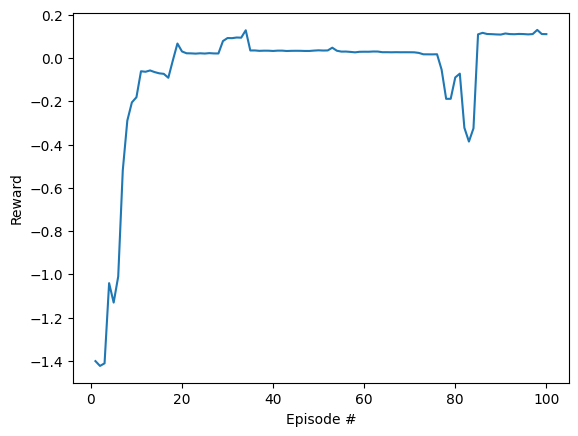

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(TOTAL_Reward)+1), TOTAL_Reward)
plt.ylabel('Reward')
plt.xlabel('Episode #')
plt.show()

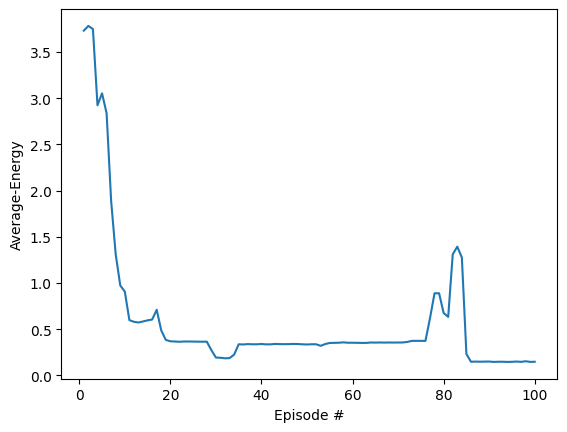

In [39]:
TOTAL_Energy
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(TOTAL_Energy)+1), TOTAL_Energy)
plt.ylabel('Average-Energy')
plt.xlabel('Episode #')
plt.show()

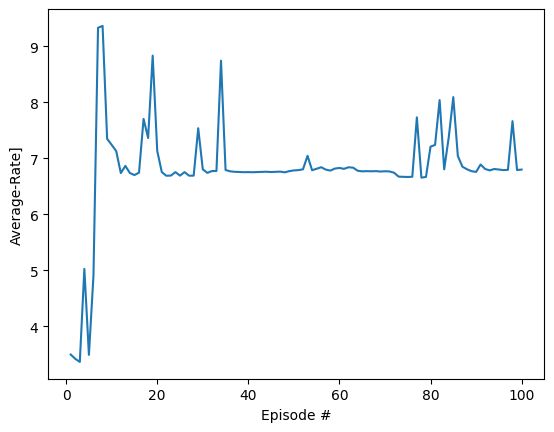

In [40]:
TOTAL_Rate
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(TOTAL_Rate)+1), TOTAL_Rate)
plt.ylabel('Average-Rate]')
plt.xlabel('Episode #')
plt.show()

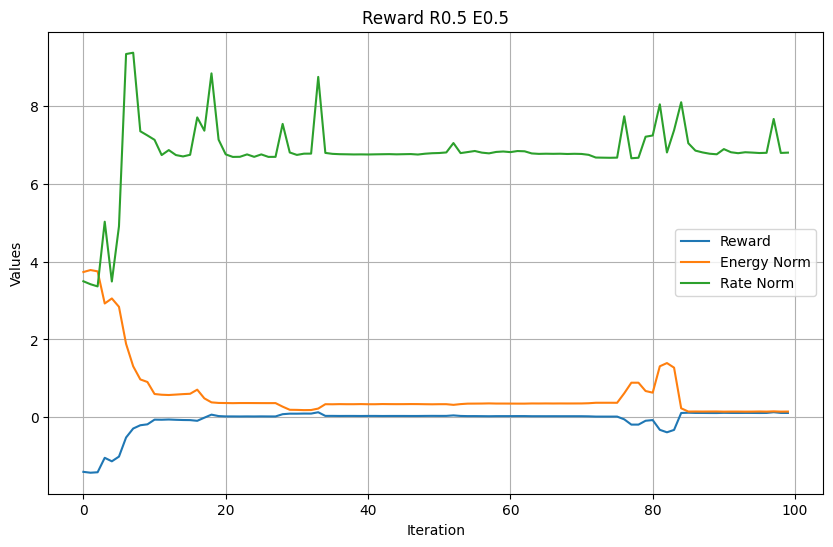

In [41]:
# Plotting
TOTAL_Energy
plt.figure(figsize=(10, 6))
plt.plot(TOTAL_Reward, label="Reward")
plt.plot(TOTAL_Energy, label="Energy Norm")
plt.plot(TOTAL_Rate, label="Rate Norm")

# Labels and Title
plt.xlabel("Iteration")
plt.ylabel("Values")
plt.title("Reward R0.5 E0.5")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [42]:
opt_action = all_action[-1]
power = [scale_action_to_power((opt_action[i]), P_min, P_max_user)  for i in range(num_user)]
power = control_power_allocation(np.array(power), P_max)
sum(power)

3.1448375883455566

In [43]:
# actual_selected(opt_action[24:44])
end_index = min(NUM_User + 2 * NUM_UAV + NUM_User, len(opt_action))    
users_select= np.array([actual_selected(opt_action[i]) for i in range(NUM_User + 2 * NUM_UAV, end_index)])
users_select


array([2.        , 0.54695413, 2.        , 2.        , 0.58452171,
       2.        , 2.        , 2.        , 2.        , 2.        ])

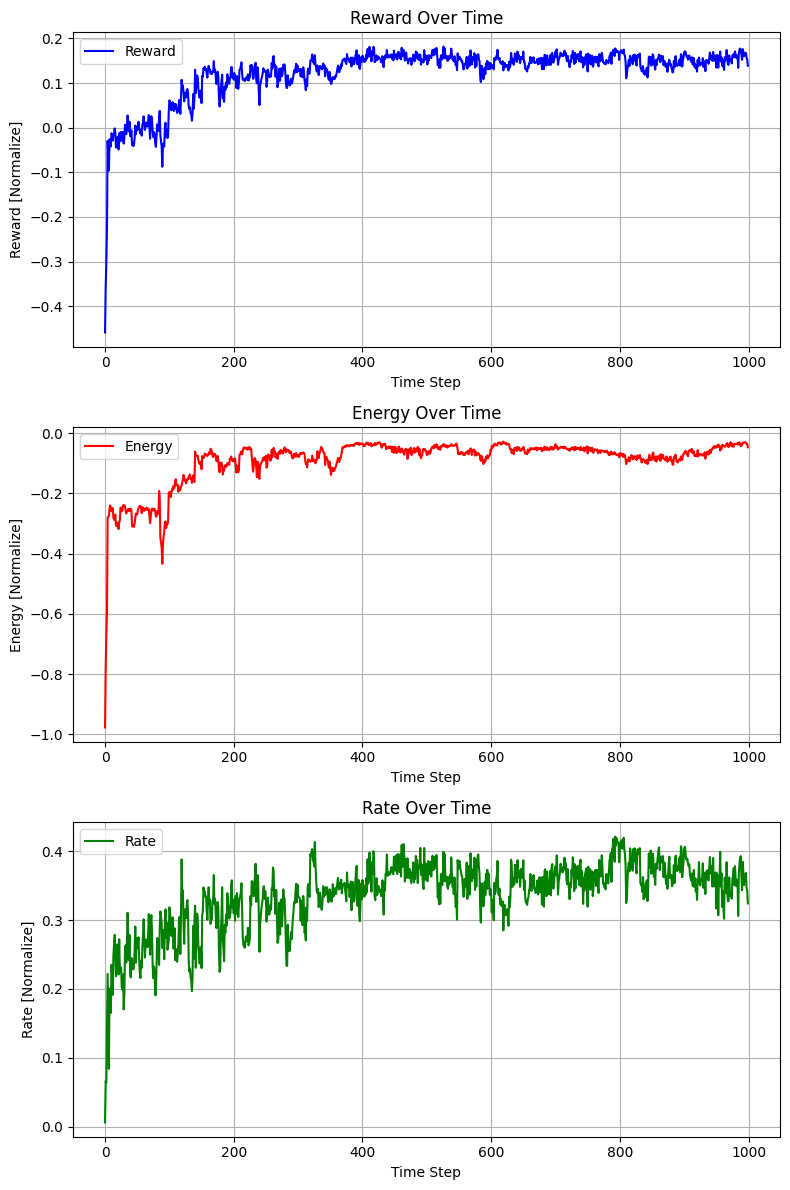

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
df = pd.read_excel("Result_all_lr_cr_1e1_data_peak16_norm.xlsx", engine="openpyxl")
df
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot Reward
axes[0].plot(df.index, df["Reward"], label="Reward", color="b")
axes[0].set_title("Reward Over Time")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Reward [Normalize]")
axes[0].legend()
axes[0].grid(True)

# Plot Energy
axes[1].plot(df.index, df["Energy"], label="Energy", color="r")
axes[1].set_title("Energy Over Time")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Energy [Normalize]")
axes[1].legend()
axes[1].grid(True)

# Plot Rate
axes[2].plot(df.index, df["Rate"], label="Rate",color="g")
axes[2].set_title("Rate Over Time")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("Rate [Normalize]")
axes[2].legend()
axes[2].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()


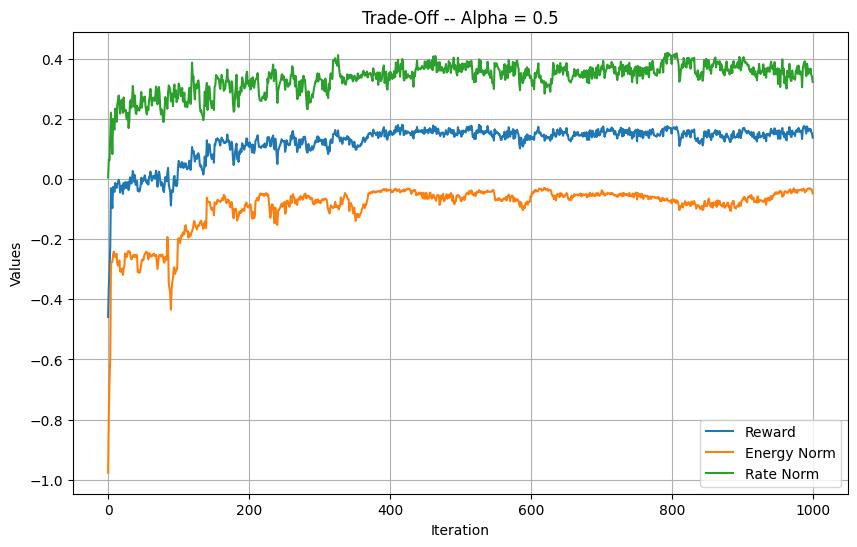

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from Excel file
file_path = "Result_all_lr_cr_1e1_data_peak16_norm.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df["Reward"], label="Reward")
plt.plot(df["Energy"], label="Energy Norm")
plt.plot(df["Rate"], label="Rate Norm")

# Labels and Title
plt.xlabel("Iteration")
plt.ylabel("Values")
plt.title("Trade-Off -- Alpha = 0.5")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


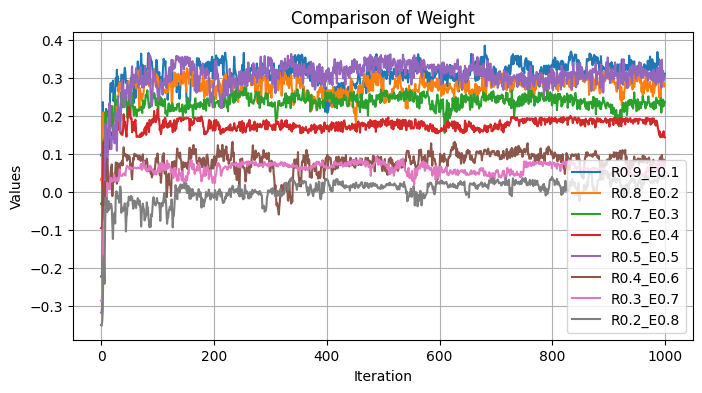

In [46]:
# Compare weight

# Load Excel file
file_path = "Result_5UAV_4t_180L_lr_cr_1e3_r0.5_e0.5.xlsx"  # Replace with your actual file path

# Read data from two sheets
df1 = pd.read_excel(file_path, sheet_name="Sheet1")  # Replace with actual sheet names

# Plot comparison
plt.figure(figsize=(8, 4))

plt.plot( df1["R0.9_E0.1"], label="R0.9_E0.1")
plt.plot(df1["R0.8_E0.2"], label="R0.8_E0.2")
plt.plot(df1["R0.7_E0.3"], label="R0.7_E0.3")
plt.plot(df1["R0.6_E0.4"], label="R0.6_E0.4")
plt.plot(df1["R0.5_E0.5"], label="R0.5_E0.5")
plt.plot(df1["R0.4_E0.6"], label="R0.4_E0.6")
plt.plot(df1["R0.3_E0.7"], label="R0.3_E0.7")
plt.plot(df1["R0.2_E0.8"], label="R0.2_E0.8")

# Labels and Title
plt.xlabel("Iteration")
plt.ylabel("Values")
plt.title("Comparison of Weight")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
